### Import PyTorch, set default type to float, check for an accelerator 

In [11]:
import torch as T
from math import sqrt

T.set_default_dtype(T.float)

if not T.cuda.is_available():
  print('Bummer no GPU')
  dev = T.device("cpu")
else:
  print('Yay: I have a GPU to keep me warm when it is cold')
  dev = T.device("cuda:0")

Yay: I have a GPU to keep me warm when it is cold


### Create & initialize MLP from specification:
  1. Create a matrix or vector of the designated dimensions
  2. Intialize the weights of each element to be i.i.d normally distributed with varying variances [see class notes]
  3. Specificy for each variable whether it is leaenable (rg=True) or fixed (rg=False)

In [12]:
def D2MLP(xdim, hdim, rg=False):
  A = T.empty(xdim, hdim, device=dev, requires_grad=rg)
  T.nn.init.normal_(A, mean=0., std=1./sqrt(xdim))
  b = T.empty(hdim, device=dev, requires_grad=rg)
  T.nn.init.normal_(b, mean=0., std=0.1/sqrt(xdim))
  w = T.empty(hdim, device=dev, requires_grad=rg)
  T.nn.init.normal_(b, mean=0., std=0.1/sqrt(xdim))
  return (A, b, w)

### Inference for a set of examples

* $X$ is of dimension $n \times d$
* $\mathbf{x}_i$ is the $i^{th}$ row of $X$ presented as a column vector
* $A$ is a matrix of dimension $d \times h$
* $\mathbf{b}$ is a vector of dimension $h$ 
* $\mathbf{w}$ is a vector of dimension $h$
* $\sigma(z) = \tanh(z) = \frac{e^{z} - e^{-z}}{e^z + e ^{-z}}$
$$\Large \mbox{Output of Network:} \;\; \hat{y} = \mathbf{w} \cdot \sigma(A^\top \mathbf{x_i} + b)$$

In [13]:
def D2predict(net, X):
  A, b, w = net
  return T.tanh(X @ A + 0.1 * b) @ w

### Loss $\ell(y,\hat{y}) = \frac{1}{|S|} \sum_{i\in S} \log(1 + e^{-y \hat{y}})$

In [14]:
def loss(y, p):
  return T.mean(T.log1p(T.exp(-y * p)))

### Training of a 2-layer (1-hidden layer) MLP

In [15]:
def D2Train(X, y, net):
  epochs, rate = 1000, 5.0
  A, b, w = net # Unpack network variables
  losses = []
  for i in range(epochs):
    # Forward / Inference
    p = D2predict(net, X)
    # Loss calculation
    l = loss(y, p)
    losses.append(l.item())
    # Backprop / Gradient Calculation
    l.backward()
    with T.no_grad():
      # Parameter updates
      A -= rate * A.grad
      b -= rate * b.grad
      w -= rate * w.grad
      # Manually zero gradients post update
      A.grad.zero_()
      b.grad.zero_()
      w.grad.zero_()
  return losses

Plotting function used in the sequel

In [16]:
def myplot(r, logscale=False):
  import matplotlib.pyplot as plt
  plt.close(), plt.ion(), plt.grid()
  _ = plt.xlabel('Epoch', fontsize=12)
  _ = plt.ylabel('Loss', fontsize=12)
  plt.plot(r, linewidth=2, linestyle='-', marker='o')
  if logscale: plt.xscale('log', basex=10.)
  plt.show(block=False)

### Experiment

  1. Create a network as a described above
  2. Create random target values $\mathbf{y}$
  3. Train
  4. Plot losses

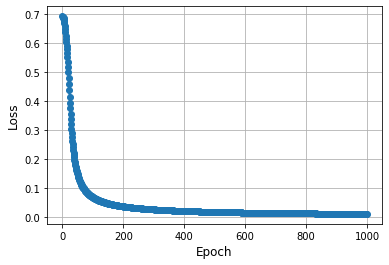

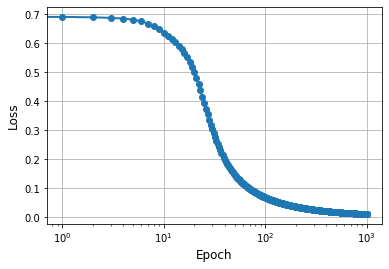

In [17]:
if T.cuda.is_available():
  n, d, h = 10000, 1000, 100
else:
  n, d, h = 1000, 100, 10
X = T.randn(n, d, device=dev)
y = T.tanh(T.randn(n, device=dev))
net = D2MLP(d, h, rg=True)
losses = D2Train(X, y, net) 

myplot(losses, logscale=False)
myplot(losses, logscale=True)